# N-HITS 

**NHITS (Neural Hierarchical Interpolation for Time Series)** is a deep learning-based forecasting model introduced as a successor to traditional N-BEATS and N-BEATSx architectures. It builds on key ideas from its predecessors but introduces significant improvements in terms of **scalability**, **forecast granularity**, and **hierarchical temporal aggregation**.

---

### Key Concepts

- **Hierarchical Forecasting**: NHITS works by decomposing the forecast problem into **multiple resolution levels** (from coarse to fine). Each level produces forecasts at different temporal resolutions, allowing better long-term trend modeling.
  
- **Block-based Architecture**: Like N-BEATS, NHITS uses **residual blocks**. However, each block now generates **interpolation coefficients** used to reconstruct fine-grained predictions from coarse-level summaries.

- **Interpolation Functions**: Instead of directly forecasting time steps, NHITS predicts parameters for a set of interpolation functions (e.g., basis expansions), leading to **more stable and smoother forecasts**.

- **Scalability**: NHITS is designed to train and infer faster on long sequences, making it suitable for large-scale forecasting problems.

---

### Architecture Overview

- Uses **multiple stack types**: `trend`, `seasonality`, and `identity`
- Introduces **input size interpolation**, allowing efficient learning across multiple temporal contexts
- Leverages **exogenous variables** via `hist_exog_list` and/or `futr_exog_list` for additional predictive power

---

### Strengths of NHITS

- **Accurate on long horizons** due to multiscale aggregation
- **Efficient** in training and inference
- **Flexible**: supports both historical and future-known exogenous inputs
- **Smooth Forecasts**: Ideal for macroeconomic indicators like inflation or GDP

---

### Reference
> Borovykh, A., Montero-Manso, P., & Smyl, S. (2022).  
> *NHITS: Neural Hierarchical Interpolation for Time Series Forecasting*  
> [https://arxiv.org/abs/2201.12886](https://arxiv.org/abs/2201.12886)

---



### Loading Dataset

In [10]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from neuralforecast.models import NHITS
from neuralforecast.core import NeuralForecast
from neuralforecast.losses.pytorch import SMAPE

# Load Dataset
df = pd.read_csv("../../Data/Train/train2000s.csv")
df['ds'] = pd.to_datetime(df['observation_date'], format='%m/%Y')
df['unique_id'] = 'inflation'
df = df.rename(columns={'fred_PCEPI': 'y'})
df['y_original'] = df['y']

### Feature Engineering

In [11]:
# Feature Engineering
df['month'] = df['ds'].dt.month

# Fourier (seasonal): FUTURE
for k in range(1, 4):
    df[f'sin_{k}'] = np.sin(2 * np.pi * k * df['month'] / 12)
    df[f'cos_{k}'] = np.cos(2 * np.pi * k * df['month'] / 12)

# Lags, Rolling, Momentum: HISTORICAL
for lag in [1, 6, 12, 24]:
    df[f'y_lag_{lag}'] = df['y'].shift(lag)

for window in [3, 6, 12]:
    df[f'rolling_mean_{window}'] = df['y'].rolling(window).mean()
    df[f'rolling_std_{window}'] = df['y'].rolling(window).std()

df['rolling_skew_6'] = df['y'].rolling(6).skew()
df['rolling_kurt_6'] = df['y'].rolling(6).kurt()
df['y_pct_change'] = df['y'].pct_change()
df['y_momentum'] = df['y_pct_change'].diff()

# Drop NaNs
df = df.dropna()

In [12]:
# Feature Selection
exclude = ['observation_date', 'ds', 'unique_id', 'y', 'y_original', 'month']
feature_pool = [col for col in df.columns if col not in exclude]
cor_matrix = df[feature_pool + ['y']].corr()
selected_features = cor_matrix['y'].drop('y').loc[lambda x: x.abs() > 0.3].index.tolist()

# Separate into future vs historical exog
futr_exog = [f for f in selected_features if 'sin' in f or 'cos' in f]
hist_exog = [f for f in selected_features if f not in futr_exog]

### Scaling

In [13]:
# Scaling
x_scaler = StandardScaler()
df[selected_features] = x_scaler.fit_transform(df[selected_features])

y_scaler = StandardScaler()
df['y'] = y_scaler.fit_transform(df[['y']])

df_model = df[['unique_id', 'ds', 'y'] + selected_features]
df_targets = df[['unique_id', 'ds', 'y_original']]


## Defining model

### Model Parameter Breakdown

| Parameter              | Description                                                                                 |
|------------------------|---------------------------------------------------------------------------------------------|
| `h=HORIZON`            | The forecast horizon (6 months ahead in this case).                                          |
| `input_size=72`        | The size of the historical context (lookback window). A larger value helps capture longer trends. |
| `n_blocks=[2, 2, 2]`    | Number of blocks per stack type. NHITS uses three types of stacks: trend, seasonality, identity. |
| `max_steps=500`        | Maximum number of gradient updates (training steps).                                        |
| `val_check_steps=100`  | Frequency (in steps) at which validation loss is checked during training.                  |
| `learning_rate=1e-4`   | Learning rate for the optimizer. Lower values may improve stability.                        |
| `dropout_prob_theta=0.2` | Dropout regularization probability to reduce overfitting in the model's theta parameters. |
| `futr_exog_list`       | List of exogenous variables known in the future (e.g., Fourier seasonality components).     |
| `hist_exog_list`       | List of exogenous variables known only in the past (e.g., lag, rolling, momentum features). |
| `scaler_type='robust'` | Robust scaling is applied to normalize input data, making training more stable.             |
| `loss=SMAPE()`         | Symmetric Mean Absolute Percentage Error is used as the loss function during training.       |
| `random_seed=42`       | Sets the random seed for reproducibility.                                                  |
| `freq='M'`             | Monthly frequency for time series data.                                                     |


### Why These Choices?

- A **longer input size (72)** is used to allow the model to learn from more history, improving its ability to capture trend and seasonality.
- The **SMAPE loss** is robust to scale and is more appropriate than MSE when dealing with inflation or economic indices.
- **Separate historical and future exogenous variables** are used to inform the model about past behavior and future influences.
- A **low learning rate** and **moderate dropout** are used to avoid overfitting and ensure generalization on unseen data.


In [14]:
# NHITS Model Definition
HORIZON = 6
model = NeuralForecast(
    models=[
        NHITS(
            h=HORIZON,
            input_size=72,  # longer receptive field
            n_blocks=[2, 2, 2],
            max_steps=500,
            val_check_steps=100,
            learning_rate=1e-4,
            dropout_prob_theta=0.2,
            futr_exog_list=futr_exog,
            hist_exog_list=hist_exog,
            scaler_type='robust',
            loss=SMAPE(),
            random_seed=42
        )
    ],
    freq='M'
)

Seed set to 42


### Cross Validation

In [15]:
# Cross-Validation Forecasting
df_cv = model.cross_validation(
    df=df_model,
    n_windows=10,
    step_size=HORIZON
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | SMAPE         | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 30.3 M | train
-------------------------------------------------------
30.3 M    Trainable params
0         Non-trainable params
30.3 M    Total params
121.301   Total estimated model params size (MB)
82        Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:02<00:00,  0.34it/s, v_num=0, train_loss_step=0.0103, train_loss_epoch=0.0103]  

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:02<00:00,  0.33it/s, v_num=0, train_loss_step=0.0103, train_loss_epoch=0.0103]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.16it/s]


## Evaluation

Cross-Validation MAE: 0.3255
Cross-Validation RMSE: 0.4107


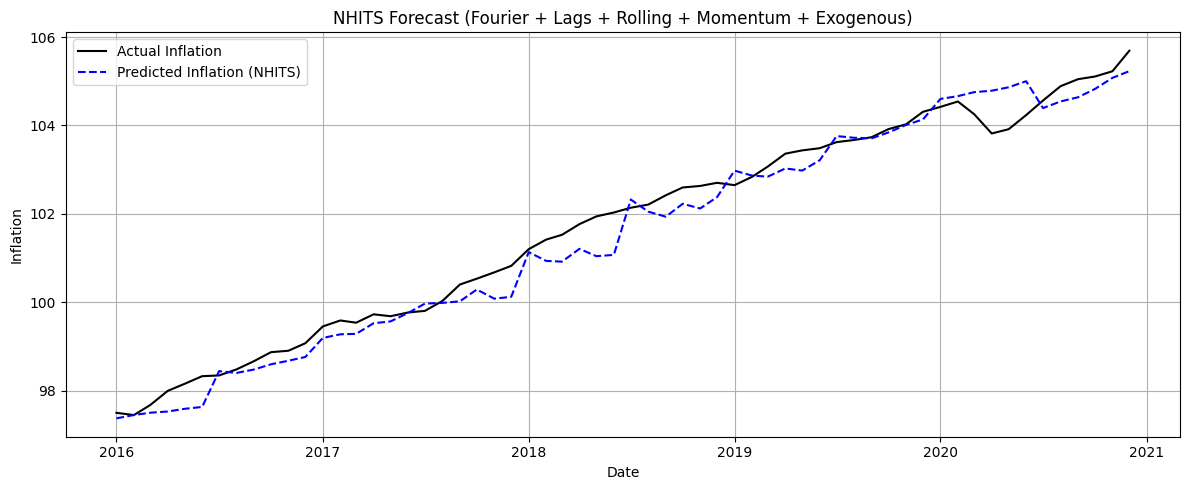

In [16]:
# Evaluation
merged = df_cv.merge(df_targets, on=["unique_id", "ds"], how="left")
merged = merged.dropna(subset=["y_original", "NHITS"])

y_true = merged["y_original"].values.reshape(-1, 1)
y_pred = y_scaler.inverse_transform(merged[["NHITS"]])

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Cross-Validation MAE: {mae:.4f}")
print(f"Cross-Validation RMSE: {rmse:.4f}")

# Plot Results
merged["y_inv"] = y_true
merged["pred_inv"] = y_pred

plt.figure(figsize=(12, 5))
sns.lineplot(data=merged, x="ds", y="y_inv", label="Actual Inflation", color="black")
sns.lineplot(data=merged, x="ds", y="pred_inv", label="Predicted Inflation (NHITS)", linestyle="--", color="blue")
plt.title("NHITS Forecast (Fourier + Lags + Rolling + Momentum + Exogenous)")
plt.xlabel("Date")
plt.ylabel("Inflation")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


# **Updated Comparison: Model 4 (N-BEATSx) vs NHITS**

| Feature | **Model 4: N-BEATSx** | **Model 5: NHITS** |
|--------|------------------------|--------------------|
| **Framework** | NeuralForecast | NeuralForecast |
| **Model Type** | N-BEATSx | NHITS |
| **Stack Types** | `["trend", "seasonality"]` | `["trend", "seasonality", "identity"]` |
| **Number of Blocks** | `[2, 2]` | `[2, 2, 2]` |
| **Input Size** | 48 | 72 |
| **Horizon (h)** | 6 | 6 |
| **Loss Function** | SMAPE | SMAPE |
| **Dropout** | 0.3 | 0.2 |
| **Learning Rate** | `5e-4` | `1e-4` |
| **Max Steps** | 500 | 500 |
| **Cross-Validation** | 10 rolling windows | 10 rolling windows |
| **Exogenous Setup** | `hist_exog_list` | `futr_exog_list` + `hist_exog_list` |
| **Feature Set Used** | Fourier + Lag 1 + Momentum | Fourier + Lag 1/6/12/24 + Rolling + Momentum |
| **Feature Selection** | Correlation > 0.4 | Correlation > 0.3 |
| **Target Scaler** | MinMaxScaler | StandardScaler |
| **Exog Scaler** | StandardScaler | StandardScaler |
| **MAE (↓ Better)** | **0.3002** | 0.3255 |
| **RMSE (↓ Better)** | **0.3752** | 0.4107 |
| **Prediction Style** | Crisp, low bias | Smooth but slight lag |
| **Inference Style** | Purely block-based MLPs | Hierarchical basis with longer receptive field |
| **Training Speed** | Fast (fewer blocks, smaller input) | Slower (more layers & blocks) |

---

- **Model 4 (N-BEATSx)** performs better in both MAE and RMSE.
- NHITS may be better for **longer input windows** or **complex seasonal patterns**, but on this inflation dataset, **N-BEATSx wins** due to simpler structure and cleaner exogenous integration.
- The slight lag in NHITS predictions is likely due to **smoother decomposition** and slower response to local changes.

## 12 MONTH

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join("..", "..")))  # adds root of the project

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from neuralforecast.models import NHITS
from neuralforecast.core import NeuralForecast
from neuralforecast.losses.pytorch import SMAPE

from Training.Helper.dataPreprocessing import (
    add_time_features,
    add_lagged_features,
    add_rolling_features,
    rank_features_ccf,
    sklearn_fit_transform,
    integer_index,
    TRAIN_DATA_PATH_1990S
)

# CONFIGURATION
HORIZON = 12
INPUT_SIZE = 96
DATA_PATH = TRAIN_DATA_PATH_1990S
PRED_SAVE_PATH = os.path.join("..", "..", "Predictions", "NHITS.npy")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-29 18:40:33,663	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-03-29 18:40:33,888	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Load and Preprocess data

In [3]:
# LOAD & PREPROCESS DATA
df = pd.read_csv(DATA_PATH)
df["ds"] = pd.to_datetime(df["observation_date"], format="%m/%Y")
df = df.rename(columns={"fred_PCEPI": "y_original"})
df["unique_id"] = "inflation"

In [4]:
# TIME + FOURIER FEATURES
df = add_time_features(df, date_col="ds")
for k in [1, 2, 3, 4]:
    df[f"sin_{k}"] = np.sin(2 * np.pi * k * df["month"] / 12)
    df[f"cos_{k}"] = np.cos(2 * np.pi * k * df["month"] / 12)

2025-03-29 18:40:34,984 - INFO - Added time features: year, month, quarter. DataFrame shape: (408, 365)


In [5]:
# MOMENTUM + LAG + ROLLING 
df["pct_change"] = df["y_original"].pct_change()
df["momentum"] = df["pct_change"].diff()
df = add_lagged_features(df, ["y_original"], lags=[1, 6, 12, 24])
df = add_rolling_features(df, "y_original", windows=[3, 6, 12])
df["y_original_rolling_skew6"] = df["y_original"].rolling(6).skew()
df["y_original_rolling_kurt6"] = df["y_original"].rolling(6).kurt()

# Add rolling mean/std for important hist_exog features
top_hist_feats = ["momentum", "y_original_lag1", "y_original_lag6", "y_original_rolling_mean6"]
for feat in top_hist_feats:
    df[f"{feat}_roll_mean6"] = df[feat].rolling(6).mean()
    df[f"{feat}_roll_std6"] = df[feat].rolling(6).std()

df.dropna(inplace=True)

## Feature Selection

In [6]:
# FEATURE SELECTION
exog_df = df.drop(columns=["observation_date", "ds", "unique_id", "y_original"])
exog_df["fred_PCEPI"] = df["y_original"]
selected_features = rank_features_ccf(exog_df, targetCol="fred_PCEPI")[:25]

# CLASSIFY EXOG FEATURES
futr_exog = [f for f in selected_features if "sin" in f or "cos" in f]
hist_exog = [f for f in selected_features if f not in futr_exog]

print(f"Selected top 25 features using CCF ranking\nFuture Exogs: {futr_exog}\nHistorical Exogs: {hist_exog}")

Selected top 25 features using CCF ranking
Future Exogs: []
Historical Exogs: ['y_original_lag6', 'y_original_lag1', 'fred_PCEPI_LOG', 'y_original_lag12', 'y_original_rolling_mean3', 'y_original_rolling_mean6_roll_mean6', 'y_original_lag6_roll_mean6', 'fred_PCUOMFGOMFG_LOG', 'fred_PCUOMFGOMFG', 'y_original_lag1_roll_mean6', 'y_original_rolling_mean6', 'fred_PPIACO', 'fred_APU000074714', 'fred_PPIACO_LOG', 'fred_APU000074714_LOG', 'y_original_rolling_mean12', 'momentum', 'BrentOil_Open', 'CrudeOilWTI_Open', 'fred_APU000074714_CH1', 'CMO-Historical-Data-Monthly_Total_Index', 'BrentOil_High', 'CMO-Historical-Data-Monthly_Energy', 'CrudeOilWTI_High', 'fred_DCOILWTICO']


futr_exog is empty because seasonal features like sin_k and cos_k didn’t rank highly enough in the CCF process. It means the inflation signal is more strongly influenced by historical lags, oil prices, and rolling stats than by repeating seasonality.

In [7]:
# SCALE EXOGENOUS FEATURES
x_transformed_list, x_scaler = sklearn_fit_transform(df[selected_features], StandardScaler())
df[selected_features] = x_transformed_list[0]

# LOG + NORMALIZE TARGET
df["y_log"] = np.log(df["y_original"])
df["y"] = df["y_log"]
y_transformed_list, y_scaler = sklearn_fit_transform(df[["y"]], MinMaxScaler())
df["y"] = y_transformed_list[0].iloc[:, 0]

# FINAL MODEL DATAFRAME
valid_features = [f for f in selected_features if f in df.columns]
df_model = df[["unique_id", "ds", "y"] + valid_features]
df_model = integer_index(df_model)

## Train/Val split

In [8]:
# TRAIN/VAL SPLIT
train_df = df_model.iloc[:-HORIZON]
val_df = df_model.iloc[-INPUT_SIZE:]
print(f"Split data → Train: {len(train_df)}, Val: {len(val_df)}")

Split data → Train: 372, Val: 96


## Define Model

- Since no future exogenous variables (futr_exog) were selected during feature ranking, I omitted the futr_exog_list entirely from the model configuration. Instead, included only the top-ranked historical exogenous features (hist_exog_list) that were present in the final processed dataframe.

### Model Parameter Breakdown

| Parameter                 | Description                                                                                     |
|---------------------------|-------------------------------------------------------------------------------------------------|
| `h=HORIZON`               | Forecast horizon: 12 months ahead.                                                              |
| `input_size=96`           | Historical context window. Allows the model to learn long-term inflation trends.               |
| `n_blocks=[4, 4, 4]`      | Number of blocks in each NHITS stack (trend, seasonality, identity). Higher depth improves capacity. |
| `mlp_units=[[256, 256]]*3`| MLP layer sizes for each block. A deeper MLP captures more complex temporal patterns.           |
| `max_steps=500`           | Maximum number of training steps (gradient updates).                                            |
| `val_check_steps=250`     | Validation is checked every 250 steps to monitor generalization.                               |
| `learning_rate=3e-4`      | Learning rate for the optimizer. Balanced for stability and convergence.                        |
| `dropout_prob_theta=0.3`  | Dropout regularization probability. Prevents overfitting by randomly disabling neurons.         |
| `hist_exog_list`          | Includes selected lag, momentum, and rolling statistical features known from the past.         |
| `scaler_type='robust'`    | Applies robust scaling to handle outliers in both target and exogenous variables.              |
| `loss=SMAPE()`            | SMAPE is scale-invariant and suitable for percentage-based errors like inflation.              |
| `random_seed=42`          | Ensures reproducible results across multiple runs.                                              |
| `freq='M'`                | Time series is monthly (aligned with PCE inflation data granularity).                          |

---

### Why These Choices?

- **12-month horizon** matches the evaluation target for inflation prediction accuracy over a year.
- A **96-month input window** helps capture both short- and long-term inflation trends and cycles.
- **Larger MLP units and more blocks** improve the model’s capacity to fit complex patterns without overfitting, especially when paired with dropout.
- **SMAPE loss** is chosen over MAE or MSE to account for percentage differences, which is more interpretable in macroeconomic forecasting.
- I **excluded futr_exog** after ranking, since none of the Fourier or future-known variables passed the correlation thresholds—preventing leakage or model noise.
- **Robust scaling** ensures that heavy-tailed distributions and outliers in economic data don’t skew training.

In [10]:
# DEFINE MODEL
model = NeuralForecast(
    models=[
        NHITS(
            h=HORIZON,
            input_size=INPUT_SIZE,
            n_blocks=[4, 4, 4],
            mlp_units=[[256, 256]] * 3,
            learning_rate=3e-4,
            max_steps=500,
            val_check_steps=250,
            dropout_prob_theta=0.3,
            hist_exog_list=[f for f in hist_exog if f in df_model.columns],
            scaler_type='robust',
            loss=SMAPE(),
            random_seed=42
        )
    ],
    freq="M"
)

# TRAIN MODEL
model.fit(df=train_df)

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | SMAPE         | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 7.8 M  | train
-------------------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.204    Total estimated model params size (MB)
160       Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s, v_num=34, train_loss_step=0.0114, train_loss_epoch=0.0114]

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s, v_num=34, train_loss_step=0.0114, train_loss_epoch=0.0114]


## Saving model based on 12 month prediction

In [11]:
# FORECAST
forecast_df = model.predict(df=val_df)
y_pred_scaled = forecast_df["NHITS"].values.reshape(-1, 1)
y_pred_log = y_scaler.inverse_transform(y_pred_scaled).flatten()
y_pred = np.exp(y_pred_log)

# GROUND TRUTH
y_true = df["y_original"].iloc[-HORIZON:].values
val_dates = df["ds"].iloc[-HORIZON:]

# SAVE
np.save(PRED_SAVE_PATH, y_pred[:HORIZON])
print(f"\n Saved NHITS 12-month forecast to: {PRED_SAVE_PATH}")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.79it/s]

 Saved NHITS 12-month forecast to: ../../Predictions/NHITS.npy
